## LSTM Classifier for Signals and Noise

This notebook demonstrate the possible use of LSTM recurrent neural network (RNN) in order to distinguish between a known signal and noise. The known signal is a 1MHz sinewave while the noise is gaussian.

- Both signal and noise is (virtually) sampled at 20MHz for a time duration of 10 milliseconds.
- Signal frequency is 1MHz
- Noise is gaussian where mean is 0 and standard deviation is 0.2.
- The extracted segments contains 1000 sample points each.
- Both signal and noise values were shifted to a range between 0 and 99 in order to use in ML.
- When creating training and testing samples, both signal and noise samples were created in equal numbers, i.e., 50% signal traces and 50% noise traces.
- Tested version: Python-3.7.2 and Tensorflow-1.13.1.

Reference:
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

### Supporting functions

In [1]:
%matplotlib inline
import numpy as np
from scipy import signal as sg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def getSignalSegment(length):
    '''
    This function generates a 1MHz sinewave along with Gaussian noise.
    Input: length of the sine wave signal segment
    Out: a numpy array containing signal segment
    '''
    # Sampling Rate
    Fs = 20e6       
    # Frequency (in Hz)
    f = 1e6               
    duration = 10e-3 # 10 milliseconds        
    # Number of samples 
    num_samples = int(duration * Fs)
    x = np.arange(num_samples)
    signal = np.sin(2 * np.pi * f * x / Fs)
    mean = 0
    std = 0.2
    noise = 2*np.random.normal(mean, std, num_samples)
    trace = signal + noise
    result = trace[0:length]
    result = 50 * result
    result[result < 0] = 0
    result[result > 99] = 99
    return result

def getNoiseSegment(length):
    '''
    This function generates a Gaussian noise.
    Input: length of the noise segment
    Out: a numpy array containing noise segment
    '''
    # Sampling Rate
    Fs = 20e6       
    duration = 10e-3 # 10 milliseconds        
    # Number of samples 
    num_samples = int(duration * Fs)
    mean = 0
    std = 0.2
    noise = 2*np.random.normal(mean, std, num_samples)
    result = noise[0:length]
    result = 50 * result
    result[result < 0] = 0
    result[result > 99] = 99
    return result

def genSamples(num_samples, length):
    '''
    This function generates a set of signal segment samples in order to be used for ML classification.
    The half of the segments are sine waves while the other half is noise segments.
    Input: number of sample segments and the length of each sample segment.
    Output: A tuple which has the sample segments and their lables.
    '''
    X = []
    Y = [] 
    num_traces=num_samples
    for i in range(int(num_traces/2)):
        signal = getSignalSegment(length)
        signal = signal.tolist()
        X.extend([signal])
        Y.append(1)
    for i in range(int(num_traces/2)):
        noise = getNoiseSegment(length)
        noise = noise.tolist()
        X.extend([noise])
        Y.append(0)
    X = np.array(X)
    Y = np.array(Y)
    return (X, Y)
    

### Plotting sample signals and noise segments

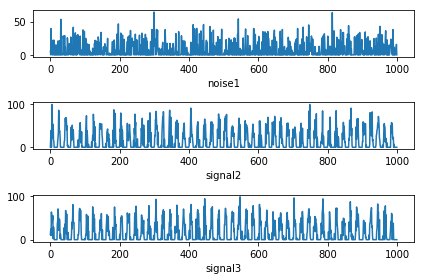

In [2]:
length=1000

signal1 = getSignalSegment(length)
#signal1 = 50 * signal1
signal2 = getSignalSegment(length)
#signal2 = 50 * signal2
signal3 = getSignalSegment(length)
#signal3 = 50 * signal3

noise1 = getNoiseSegment(length)
#noise1 = 50 * noise1
noise2 = getNoiseSegment(length)
#noise2 = 50 * noise2

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(noise1)
plt.xlabel("noise1")
plt.subplot(3, 1, 2)
plt.plot(signal2)
plt.xlabel("signal2")
plt.subplot(3, 1, 3)
plt.plot(signal3)
plt.xlabel("signal3")
plt.tight_layout()
plt.show()

### Generating samples for machine learning classification

In [3]:
# Generating signal samples
length=1000
X, y = genSamples(5000, length)
print(X.shape)
print(y.shape)

# Splitting samples to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5000, 1000)
(5000,)
(3750, 1000)
(3750,)
(1250, 1000)
(1250,)


### LSTM classification of signal and noise

In [4]:
# LSTM for sequence classification in the IMDB dataset
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# fix random seed for reproducibility
numpy.random.seed(7)

# value range of the segment values 
value_range = 100 # because the value range of each sample point is between 0 and 99 (see plot)

# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(value_range, embedding_vecor_length, input_length=length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#model.fit(X_train, y_train, epochs=10, batch_size=64)
model.fit(X_train, y_train, epochs=5, batch_size=64)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 32)          3200      
_________________________________________________________________
dropout (Dropout)            (None, 1000, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 56,501
Trainable params: 56,501
Non-trainable params: 0
_________________